In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dataloader import CTScanData
from vit_model import VisionTransformer3D, UpsampleAttentionMap
import random
from sklearn.model_selection import train_test_split
from monai.transforms import (
    Compose, EnsureChannelFirst, ScaleIntensity, RandRotate90, RandFlip,
    RandZoom, RandGaussianNoise, SpatialPad, RandAffine, ToNumpy, ToTensor
)
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Function to remove 'module.' prefix from state_dict keys
def remove_module_prefix(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_state_dict[k[7:]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

In [4]:
# Load model
in_channels = 1
d_model = 256
feedforward_dim = 512
num_heads = 8
patch_size = 16
num_layers = 8
num_classes = 2

model = VisionTransformer3D(in_channels, d_model, feedforward_dim, patch_size, num_classes=num_classes, num_layers=num_layers)
state_dict = torch.load('./Data/results_2/epoch_430_model.pt')
state_dict = remove_module_prefix(state_dict)  # Remove 'module.' prefix
model.load_state_dict(state_dict)
model.to(device)
model.eval()

VisionTransformer3D(
  (patch_embedding): PatchEmbedding3D(
    (proj): Conv3d(1, 256, kernel_size=(16, 16, 16), stride=(16, 16, 16))
  )
  (transformerlayers): ModuleList(
    (0-7): 8 x TransformerBlock(
      (attention_layer): Attention(
        (qkv_layer): Linear(in_features=256, out_features=768, bias=False)
        (dropout_layer): Dropout(p=0.0, inplace=False)
        (softmax_layer): Softmax(dim=-1)
        (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (linear_layer): Linear(in_features=256, out_features=256, bias=True)
      )
      (feedforward_layer): FeedForward(
        (net): Sequential(
          (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=256, out_features=512, bias=True)
          (2): GELU(approximate='none')
          (3): Dropout(p=0.0, inplace=False)
          (4): Linear(in_features=512, out_features=256, bias=True)
          (5): Dropout(p=0.0, inplace=False)
        )
      )
    )


In [6]:
def evaluate_model(model, data_loader):
    correct = 0
    total = 0
    all_targets = []
    all_preds = []
    all_probs = []

    # with torch.no_grad():
    #     for inputs, labels in validation_loader:
    #         inputs, labels = inputs.to(device), labels.to(device)
    #         outputs, attn_weights = model(inputs)

            
    #         _, preds = torch.max(outputs, 1)
    #         total += labels.size(0)
    #         correct += (preds == labels).sum().item()


    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, attn_weights = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities
            preds = torch.argmax(probs, dim=1)    # Predicted class

            correct += (preds == targets).sum().item()
            total += targets.size(0)

            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = correct / total
    return accuracy, np.array(all_targets), np.array(all_preds), np.array(all_probs)

In [7]:
torch.manual_seed(1234567890)
print('Reading Data...')
df = pd.read_excel('./Data/image_data.xlsx')
dataset = CTScanData(df)
df = df.sample(frac=1).reset_index(drop=True)
print('Data reading success!')
test_size = 0.25

train_set, valid_set = train_test_split(df, test_size=test_size, stratify=df['target'])
train_sampler = list(train_set.index)
valid_sampler = list(valid_set.index)

print('Preparing Dataloader')

train_transforms = Compose([
        ScaleIntensity(),
        RandRotate90(prob=0.5),
        RandFlip(prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        RandGaussianNoise(prob=0.5),
        EnsureChannelFirst(channel_dim="no_channel"),
        # SpatialPad((224, 224, 224)),
        # RandAffine(prob=0.5),
        ToTensor()
    ])

val_transforms = Compose([
        ScaleIntensity(),
        EnsureChannelFirst(channel_dim="no_channel"),
        # SpatialPad((224, 224, 224)),
        ToTensor()
    ])

train_dataset = CTScanData(df.iloc[train_sampler].reset_index(drop=True), transform=train_transforms)
validation_dataset = CTScanData(df.iloc[valid_sampler].reset_index(drop=True), transform=val_transforms)


Reading Data...
Data reading success!
Preparing Dataloader


In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=4)

In [10]:
# Train Accuracy
train_acc, y_train_true, y_train_preds, y_train_probs = evaluate_model(model, train_loader)
print(f"Train Accuracy: {train_acc:.4f}")

Train Accuracy: 0.8358


In [11]:
# Test Accuracy
test_acc, y_test_true, y_test_preds, y_test_probs = evaluate_model(model, validation_loader)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8261


In [12]:
def compute_metrics(y_true, y_preds, num_classes):
    conf_matrix = confusion_matrix(y_true, y_preds)
    TP = np.diag(conf_matrix)  # True Positives are on the diagonal
    FP = conf_matrix.sum(axis=0) - TP  # Column sum - TP
    FN = conf_matrix.sum(axis=1) - TP  # Row sum - TP
    TN = conf_matrix.sum() - (TP + FP + FN)  # Total - (TP + FP + FN)

    sensitivity = TP / (TP + FN)  # Recall
    specificity = TN / (TN + FP)
    return TP, FP, TN, FN, sensitivity, specificity

# Metrics for Test Data
TP, FP, TN, FN, sensitivity, specificity = compute_metrics(y_test_true, y_test_preds, num_classes=2)

print("Class-wise Metrics:")
for i in range(2):
    print(f"Class {i}: TP={TP[i]}, FP={FP[i]}, TN={TN[i]}, FN={FN[i]}, Sensitivity={sensitivity[i]:.4f}, Specificity={specificity[i]:.4f}")


Class-wise Metrics:
Class 0: TP=12, FP=2, TN=7, FN=2, Sensitivity=0.8571, Specificity=0.7778
Class 1: TP=7, FP=2, TN=12, FN=2, Sensitivity=0.7778, Specificity=0.8571


In [14]:
print(classification_report(y_test_true, y_test_preds))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.78      0.78      0.78         9

    accuracy                           0.83        23
   macro avg       0.82      0.82      0.82        23
weighted avg       0.83      0.83      0.83        23



In [17]:
df_rf = pd.read_excel("C:\\Users\\Admin\\Desktop\\AI-Projects\\Individual_projects\\Alex\\Cardiac_CT\\test_trues_preds.xlsx")
df_rf.head()

,y_trues_test,y_preds_test
0,0,0
1,0,0
2,1,0
3,0,0
4,1,1


In [35]:
from scipy.interpolate import interp1d
def plot_multi_class_roc(y_true_list, y_scores_list, model_names, phase):
    plt.figure(figsize=(10, 6))
    for y_true, y_scores, model_name in zip(y_true_list, y_scores_list, model_names):
#         if model_name == 'Combined':
        y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
        y_scores = np.array(y_scores)
        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
        if model_name == 'Fold7':
            tpr = [0.1]*len(tpr)
        roc_auc = auc(fpr, tpr)
        # fpr_new = np.linspace(0, 1, 1000) 
        # tpr_interpolated = interp1d(fpr, tpr, kind='linear')(fpr_new)  

        plt.plot(fpr, tpr, lw=2, label='%s (AUC = %0.2f)' % (model_name, roc_auc))
        # plt.plot(fpr_new, tpr_interpolated, lw=2, label='%s (AUC = %0.2f)' % (model_name, roc_auc))
        print(f'DONE: {model_name}')
        
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve in {phase} Phase')
    plt.legend(loc='lower right')
    plt.show()

In [36]:
y_trues_list = [list(df_rf['y_trues_test']), list(y_test_true)]
y_scores_list = [list(df_rf['y_preds_test']), list(y_test_preds)]
model_names = ['Radiomics - Random Forest', 'Imaging - 3D Vision Transformer']

DONE: Radiomics - Random Forest
DONE: Imaging - 3D Vision Transformer


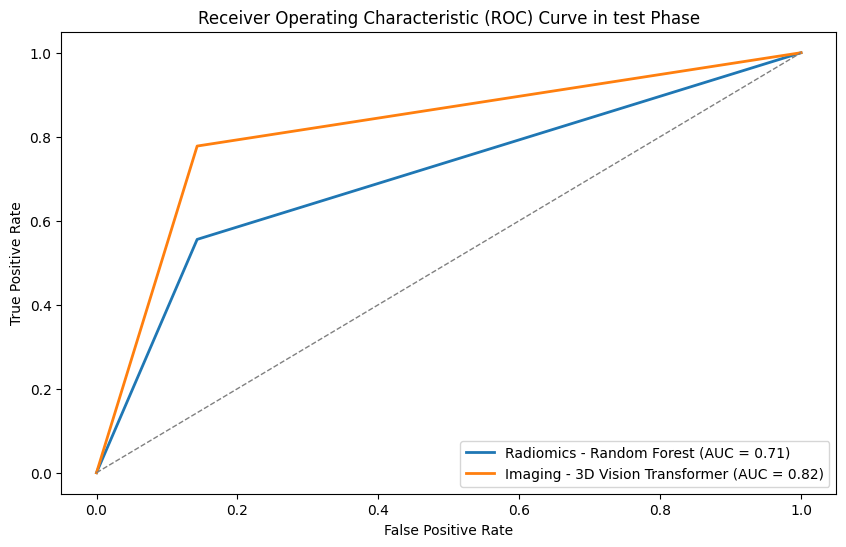

In [37]:
plot_multi_class_roc(y_trues_list, y_scores_list, model_names, 'test')